In [4]:

import commentjson
import os
#os.chdir('/mnt/batch/tasks/shared/LS_root/mounts/clusters/pythonnb/code/Users/david.mouquet/modeling')


import missingno as msno
import sys
import importlib
import pandas as pd
import math
import datetime

sys.path.append("../../SRC/")

import importFromUV as preprocdata
importlib.reload(preprocdata)
from sklearn.metrics import r2_score


In [5]:
file_model_param   = "../../MODELISATION/models_param/TCC-DK-Elec-Mop.json"

model_id           = "R1V1_2022_Facteurs_Leviers"
site               = "DK-TCC"


dir_models  = "C:/Users/33623/Dropbox (Ultiwatt)/D - ULTIVISION INDUSTRIES/4-ARCELORMITTAL/2- DEPLOIEMENT AMF/2-Projet LOT 2/10-Models/"
dir_result  = dir_models + site + "/" + model_id 
model_name  = dir_result + "/" + "model.pkl"



isExist = os.path.exists(dir_result)

if not isExist:
  # Create a new directory because it does not exist 
  os.mkdir(dir_result)

###############################################################

with open(file_model_param, encoding='utf-8') as file:
    dico_model_all = commentjson.load(file)

dico_model = dico_model_all[model_id]



#pkl_model_name      = "resu/models/"+model_id+"_"+ dico_model['type_model'] + "_" +dico_model['freq']+".pkl"

onnx_model_name     = dico_model['mangling']+"."+model_id+".onnx"
nom_model_registre  = dico_model['nom_model_registre']
freq                = dico_model['freq']
uv_mangling         = dico_model['mangling']
nom_data_store      = dico_model['data_store']


ref_periode_debut = datetime.datetime.strptime(dico_model['ref_periode_debut'], '%d/%m/%Y %H:%M:%S').isoformat()
ref_periode_fin   = datetime.datetime.strptime(dico_model['ref_periode_fin'], '%d/%m/%Y %H:%M:%S').isoformat()

In [6]:
data, clean_report = preprocdata.Charger_Preparer_Data(ref_periode_debut = ref_periode_debut, 
                                         ref_periode_fin   = ref_periode_fin,
                                         ipe_tag           = dico_model["tag_modelise"],
                                         dico_du_model     = dico_model,
                                         use_seuil_min     = True,
                                         use_seuil_max     = True,
                                         clean_data        = False,
                                         concat_after      = True,
                                         load_unused_feature = True,
                                         zscore            = 3)

import du tag: tag_4278
import du tag: tag_10260
import du tag: tag_10261
import du tag: tag_3359
import du tag: tag_3361
import du tag: tag_35633
import du tag: tag_3931
import du tag: tag_9323
import du tag: tag_3928


In [11]:
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

# Réseau de neuronnes

## définition du preprocesseur

In [93]:
subdata = data.copy()


features = subdata.copy()
target   = features.pop('DK_TCC_Laminoir_R1V1_IPE_ELEC_EN_CHARGE_kWh_BOB')


In [94]:
inputs = {}

for name, column in features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

In [95]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(subdata[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)


In [96]:
preprocessed_inputs = [all_numeric_inputs]

In [97]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue

  lookup = layers.StringLookup(vocabulary=np.unique(features[name]))
  one_hot = layers.CategoryEncoding(max_tokens=lookup.vocab_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

In [98]:
preprocessed_inputs

[<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'normalization_5')>,
 <KerasTensor: shape=(None, 45) dtype=float32 (created by layer 'category_encoding_3')>]

In [99]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
model_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

In [100]:
features_dict = {name: np.array(value) 
                         for name, value in features.items()}

In [101]:
model_preprocessing(features_dict)

<tf.Tensor: shape=(280159, 52), dtype=float32, numpy=
array([[ 0.013, -1.376, -1.647, ...,  0.   ,  0.   ,  0.   ],
       [-0.375, -1.376, -1.647, ...,  0.   ,  0.   ,  0.   ],
       [-0.325,  0.546,  0.604, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [-0.108, -1.085, -1.647, ...,  0.   ,  0.   ,  0.   ],
       [-0.266,  0.464,  0.604, ...,  0.   ,  0.   ,  0.   ],
       [-0.266,  0.48 ,  0.604, ...,  0.   ,  0.   ,  0.   ]],
      dtype=float32)>

## construction du modèle

In [102]:
def build_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model


In [103]:
final_model = build_model(model_preprocessing, inputs)

In [104]:
history = final_model.fit(x=features_dict, y=target, epochs=20,validation_split=0.2)

Epoch 1/20
7004/7004 [==============================] - 13s 2ms/step - loss: 5.5045 - val_loss: 2.8671
Epoch 2/20
7004/7004 [==============================] - 12s 2ms/step - loss: 2.7404 - val_loss: 2.7811
Epoch 3/20
7004/7004 [==============================] - 12s 2ms/step - loss: 2.6841 - val_loss: 2.7687
Epoch 4/20
7004/7004 [==============================] - 12s 2ms/step - loss: 2.6587 - val_loss: 2.7259
Epoch 5/20
7004/7004 [==============================] - 12s 2ms/step - loss: 2.6399 - val_loss: 2.6919
Epoch 6/20
7004/7004 [==============================] - 12s 2ms/step - loss: 2.6281 - val_loss: 2.6814
Epoch 7/20
7004/7004 [==============================] - 12s 2ms/step - loss: 2.6197 - val_loss: 2.7077
Epoch 8/20
7004/7004 [==============================] - 12s 2ms/step - loss: 2.6124 - val_loss: 2.6989
Epoch 9/20
7004/7004 [==============================] - 12s 2ms/step - loss: 2.6054 - val_loss: 2.6792
Epoch 10/20
7004/7004 [==============================] - 12s 2ms/step - l

In [87]:
def plot_loss(history):
  import matplotlib.pyplot as plt
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

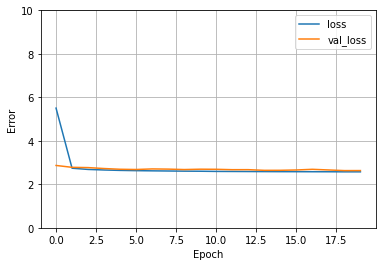

In [105]:
plot_loss(history)

In [106]:
test_predictions = final_model.predict(features_dict).flatten()

8755/8755 [==============================] - 12s 1ms/step


In [107]:
test_predictions

array([26.246, 22.442, 71.341, ..., 25.733, 48.52 , 52.172], dtype=float32)

In [109]:
r2_score(target.values,test_predictions)

0.9549839601612287

## Export au format ONNX

In [110]:
final_model.save('model_ts')

INFO:tensorflow:Assets written to: model_ts\assets


INFO:tensorflow:Assets written to: model_ts\assets


In [ ]:
import tensorflow as tf
import tf2onnx

model = tf.keras.models.load_model('model_ts')

tf2onnx.convert.from_keras(model, output_path='model_R1V1_ts_test.onnx')

# Gradient Boost tree

In [113]:
data.head()

,DK_TCC_Laminoir_R1V1_IPE_ELEC_EN_CHARGE_kWh_BOB,R1V1_Taux_reduction_epaisseur,R1V1_Refoulement,Code_Metal,D_NBPASSE,Tps_Entree_TCC_Sortie_R1V1,LARG_BRAME_THEOR,teta_moy_v1r1,Longueur_Brame
Date,,,,,,,,,
2021-01-02 07:09:01,20.422205,20.922974,0.000000,1,1.0,31.049664,1200.947021,1176.389160,9.695
2021-01-02 07:14:59,17.806858,20.094247,0.000000,1,1.0,29.648962,1201.945068,1195.322998,8.575
2021-01-02 07:17:19,65.539217,20.201968,134.161377,4,3.0,80.729557,1438.000000,1148.741943,8.375
2021-01-02 07:21:15,36.818706,20.322960,57.334839,4,3.0,80.288519,1438.000000,1187.278564,8.375
2021-01-02 07:23:57,41.417185,20.475834,40.297974,33,1.0,34.272558,1440.000000,1204.938721,9.500


In [116]:
dftrain = subdata.sample(frac=0.8, random_state=0)
dfeval  = subdata.drop(dftrain.index)

y_train = dftrain.pop('DK_TCC_Laminoir_R1V1_IPE_ELEC_EN_CHARGE_kWh_BOB')
y_eval  = dfeval.pop('DK_TCC_Laminoir_R1V1_IPE_ELEC_EN_CHARGE_kWh_BOB')

In [118]:
dftrain.columns

Index(['R1V1_Taux_reduction_epaisseur', 'R1V1_Refoulement', 'Code_Metal',
       'D_NBPASSE', 'Tps_Entree_TCC_Sortie_R1V1', 'LARG_BRAME_THEOR',
       'teta_moy_v1r1', 'Longueur_Brame'],
      dtype='object')

In [120]:
fc = tf.feature_column

CATEGORICAL_COLUMNS = ['Code_Metal']
NUMERIC_COLUMNS     = ['R1V1_Taux_reduction_epaisseur', 'R1V1_Refoulement','D_NBPASSE', 'Tps_Entree_TCC_Sortie_R1V1', 'LARG_BRAME_THEOR','teta_moy_v1r1', 'Longueur_Brame']

In [121]:

  
def one_hot_cat_column(feature_name, vocab):
  return tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(feature_name,
                                                                vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                                          dtype=tf.float32))

In [122]:
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [ ]:
tf.estimator.Booste

In [123]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset. 
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
result = est.evaluate(eval_input_fn)

AttributeError: module 'tensorflow_estimator.python.estimator.api._v2.estimator' has no attribute 'BoostedTreesClassifier'